In [1]:
# Dependencies and Setup
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time 
import datetime 
import numpy as np
from config1 import username1,password1,host1,port1,database1,census_key
from config2 import username2,password2,host2,port2,database2
import sqlalchemy
from sqlalchemy import create_engine, func, inspect, desc
pd.options.mode.chained_assignment = None  # default='warn'
import requests
import json
from pandas.io.json import json_normalize
from timeit import default_timer as timer
from census import Census
from us import states
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import statistics

Using TensorFlow backend.


In [2]:
# Database Setup
start = timer()
connection1=f'{username1}:{password1}@{host1}:{port1}/{database1}'
engine1 = create_engine(f'postgresql://{connection1}')

# Pull Data
state_heatmap=pd.read_sql_query('select * from state_heatmap', con=engine1)
county_heatmap=pd.read_sql_query('select * from county_heatmap', con=engine1)
state_cases=pd.read_sql_query('select * from state_cases', con=engine1)
state_deaths=pd.read_sql_query('select * from state_deaths', con=engine1)
county_cases1=pd.read_sql_query('select * from county_cases1', con=engine1)
county_cases2=pd.read_sql_query('select * from county_cases2', con=engine1)
county_cases3=pd.read_sql_query('select * from county_cases3', con=engine1)
county_deaths1=pd.read_sql_query('select * from county_deaths1', con=engine1)
county_deaths2=pd.read_sql_query('select * from county_deaths2', con=engine1)
county_deaths3=pd.read_sql_query('select * from county_deaths3', con=engine1)

# Concats
county_cases=pd.concat([county_cases1,county_cases2,county_cases3], ignore_index=True)
county_deaths=pd.concat([county_deaths1,county_deaths2,county_deaths3], ignore_index=True)
end = timer()
print(end - start)

9.676678899999999


In [3]:
# Call Cencus Data
start = timer()
c = Census(census_key, year=2018)
census_data = c.acs5.get(('B01003_001E', 'B17001_002E'), {'for': 'county:*'})

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column Reordering
census_df= census_df.rename(columns={'B01003_001E': 'Population',
                                      'B17001_002E': 'Poverty Count',
                                      'state':'State',
                                     'county':'County'})


census_df['fips']=census_df['State']+census_df['County']
state_census=census_df.groupby("State")["Population",'Poverty Count'].sum()
state_census=state_census.reset_index()
state_census=state_census.rename(columns={'State':'fips'})
end = timer()
print(end - start)

2.6029718000000006


C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [4]:
start = timer()
state_area={}
with open('stateborders.json') as json_file:
    data = json.load(json_file)
data=data['features']
k=0
for state in data:
    state_area[k] = {"state":data[k]['properties']['NAME'],"fips": data[k]['properties']['STATE'],
                     "area": data[k]['properties']['CENSUSAREA']}
    k=k+1
state_area = pd.DataFrame.from_dict(state_area, "index")

county_area={}
with open('countyborders.json') as json_file:
    data = json.load(json_file)
data=data['features']
k=0
for county in data:
    county_area[k] = {"fips": (data[k]['properties']['STATE'])+(data[k]['properties']['COUNTY']),
                      "area": data[k]['properties']['CENSUSAREA']}
    k=k+1
county_area = pd.DataFrame.from_dict(county_area, "index")
end = timer()
print(end - start)

0.9460030999999987


In [5]:
start = timer()
state_census=state_census.merge(state_area, on='fips')
state_census.iloc[8,3]='District Of Columbia'
county_census=census_df.merge(county_area, on='fips')
county_census.iloc[291,1]=10300
state_census['Poverty Rate'] = 100 * \
    state_census['Poverty Count'].astype(
        int) / state_census['Population'].astype(int)
state_census['Population Density'] = 1 * \
    state_census['Population'].astype(
        int) / state_census['area'].astype(int)
state_census=state_census.drop(['Poverty Count','Population','area'], axis=1)
# Convert Poverty Copunt to Poverty Rate (Poverty Count / Population)
county_census['Poverty Rate'] = 100 * \
    county_census['Poverty Count'].astype(
        int) / county_census['Population'].astype(int)
county_census['Population Density'] = 1 * \
    county_census['Population'].astype(
        int) / county_census['area'].astype(int)
county_census=county_census.drop(['Poverty Count','Population','area','State','County'], axis=1)
end = timer()
print(end - start)

0.010637800000001363


In [6]:
county_heatmap=county_heatmap.merge(county_census,on='fips')
state_heatmap=state_heatmap.merge(state_census,on='state')

In [7]:
#Find daily totals - county cases
start = timer()
county_cases_daily=county_cases.copy()
[r,c]=county_cases_daily.shape
for j in range (0,r):
    last=0
    for i in range (3,c):
        current=county_cases_daily.iloc[j,i]-last
        last=county_cases_daily.iloc[j,i]
        county_cases_daily.iat[j,i]=current
end = timer()
print(end - start)        

start = timer()
#Find daily totals - county deaths
county_deaths_daily=county_deaths.copy()
[r,c]=county_deaths_daily.shape
for j in range (0,r):
    last=0
    for i in range (3,c):
        current=county_deaths_daily.iloc[j,i]-last
        last=county_deaths_daily.iloc[j,i]
        county_deaths_daily.iat[j,i]=current
end = timer()
print(end - start)

9.456422800000002
9.577915


In [8]:
#Find daily totals - state cases
start = timer()
state_cases_daily=state_cases.copy()
[r,c]=state_cases_daily.shape
for j in range (0,r):
    last=0
    for i in range (2,c):
        current=state_cases_daily.iloc[j,i]-last
        last=state_cases_daily.iloc[j,i]
        state_cases_daily.iat[j,i]=current
end = timer()
print(end - start)

#Find daily totals - state deaths
start = timer()
state_deaths_daily=state_deaths.copy()
[r,c]=state_deaths_daily.shape
for j in range (0,r):
    last=0
    for i in range (2,c):
        current=state_deaths_daily.iloc[j,i]-last
        last=state_deaths_daily.iloc[j,i]
        state_deaths_daily.iat[j,i]=current
end = timer()
print(end - start)

0.16096809999999806
0.17737720000000223


In [9]:
#Find daily totals - county cases
start = timer()
county_cases_7day=county_cases_daily.copy()
[r,c]=county_cases_7day.shape
for j in range (0,r):
    for i in range (9,c):
        county_cases_7day.iloc[j,i]=statistics.mean([county_cases_daily.iloc[j,i-6],county_cases_daily.iloc[j,i-5],
                county_cases_daily.iloc[j,i-4],county_cases_daily.iloc[j,i-3],county_cases_daily.iloc[j,i-3],
                county_cases_daily.iloc[j,i-1],county_cases_daily.iloc[j,i]])
county_cases_7day = county_cases_7day.drop([county_cases_7day.columns[3],county_cases_7day.columns[4],
                                         county_cases_7day.columns[5],county_cases_7day.columns[6],
                                         county_cases_7day.columns[7],county_cases_7day.columns[8]],axis=1)
end = timer()
print(end - start)        

start = timer()
#Find daily totals - county deaths
county_deaths_7day=county_deaths_daily.copy()
[r,c]=county_deaths_7day.shape
for j in range (0,r):
    last=0
    for i in range (9,c):
        county_deaths_7day.iloc[j,i]=statistics.mean([county_deaths_daily.iloc[j,i-6],county_deaths_daily.iloc[j,i-5],
                county_deaths_daily.iloc[j,i-4],county_deaths_daily.iloc[j,i-3],county_deaths_daily.iloc[j,i-3],
                county_deaths_daily.iloc[j,i-1],county_deaths_daily.iloc[j,i]])
county_deaths_7day = county_deaths_7day.drop([county_deaths_7day.columns[1],county_deaths_7day.columns[2],
                                         county_deaths_7day.columns[3],county_deaths_7day.columns[4],
                                         county_deaths_7day.columns[5],county_deaths_7day.columns[6]],axis=1)
end = timer()
print(end - start)

173.8694178
173.24679490000003


In [10]:
#Find daily totals - state cases
start = timer()
state_cases_7day=state_cases_daily.copy()
[r,c]=state_cases_7day.shape
for j in range (0,r):
    for i in range (9,c):
        state_cases_7day.iloc[j,i]=statistics.mean([state_cases_daily.iloc[j,i-6],state_cases_daily.iloc[j,i-5],
                state_cases_daily.iloc[j,i-4],state_cases_daily.iloc[j,i-3],state_cases_daily.iloc[j,i-3],
                state_cases_daily.iloc[j,i-1],state_cases_daily.iloc[j,i]])
state_cases_7day = state_cases_7day.drop([state_cases_7day.columns[1],state_cases_7day.columns[2],
                                         state_cases_7day.columns[3],state_cases_7day.columns[4],
                                         state_cases_7day.columns[5],state_cases_7day.columns[6]],axis=1)
end = timer()
print(end - start)        

start = timer()
#Find daily totals - county deaths
state_deaths_7day=state_deaths_daily.copy()
[r,c]=state_deaths_7day.shape
for j in range (0,r):
    last=0
    for i in range (9,c):
        state_deaths_7day.iloc[j,i]=statistics.mean([state_deaths_daily.iloc[j,i-6],state_deaths_daily.iloc[j,i-5],
                state_deaths_daily.iloc[j,i-4],state_deaths_daily.iloc[j,i-3],state_deaths_daily.iloc[j,i-3],
                state_deaths_daily.iloc[j,i-1],state_deaths_daily.iloc[j,i]])
state_deaths_7day = state_deaths_7day.drop([state_deaths_7day.columns[1],state_deaths_7day.columns[2],
                                         state_deaths_7day.columns[3],state_deaths_7day.columns[4],
                                         state_deaths_7day.columns[5],state_deaths_7day.columns[6]],axis=1)
end = timer()
print(end - start)

2.780113800000038
2.696200000000033


In [11]:
start = timer()
state_cases_popcorrected={}
k=0
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    pov=state_heatmap.iloc[j,13]
    popden=state_heatmap.iloc[j,14]
    for i in range (7,c-7):
        if state_cases.iloc[j,i+1]>0:
            state_cases_popcorrected[k] = {"pov": pov,"popden": popden,"day1": (state_cases.iloc[j,i]*100000)/pop,
"day2":(state_cases.iloc[j,i+1]*100000)/pop,"day3":(state_cases.iloc[j,i+2]*100000)/pop,
"day4":(state_cases.iloc[j,i+3]*100000)/pop,"day5":(state_cases.iloc[j,i+4]*100000)/pop,
"day6":(state_cases.iloc[j,i+5]*100000)/pop,"day7":(state_cases.iloc[j,i+6]*100000)/pop,
"7day1": (state_cases_7day.iloc[j,i-6]*100000)/pop,"7day2":(state_cases_7day.iloc[j,i-5]*100000)/pop,
"7day3":(state_cases_7day.iloc[j,i-4]*100000)/pop,"7day4":(state_cases_7day.iloc[j,i-3]*100000)/pop,
"7day5":(state_cases_7day.iloc[j,i-2]*100000)/pop,"7day6":(state_cases_7day.iloc[j,i-1]*100000)/pop,
"7day7":(state_cases_7day.iloc[j,i]*100000)/pop,"7day8":(state_cases_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
state_cases_popcorrected = pd.DataFrame.from_dict(state_cases_popcorrected, "index")
end = timer()
print(end - start)

0.7637617000000319


In [12]:
start = timer()
state_deaths_popcorrected={}
k=0
[r,c]=state_deaths.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    pov=state_heatmap.iloc[j,13]
    popden=state_heatmap.iloc[j,14]
    for i in range (7,c-7):
        if state_deaths.iloc[j,i+1]>0:
            state_deaths_popcorrected[k] = {"pov":pov,"popden":popden,"casesday1":(state_cases.iloc[j,i]*100000)/pop,
"casesday2":(state_cases.iloc[j,i+1]*100000)/pop,"casesday3":(state_cases.iloc[j,i+2]*100000)/pop,
"casesday4":(state_cases.iloc[j,i+3]*100000)/pop,"casesday5":(state_cases.iloc[j,i+4]*100000)/pop,
"casesday6":(state_cases.iloc[j,i+5]*100000)/pop,"casesday7":(state_cases.iloc[j,i+6]*100000)/pop,
"7caseday1": (state_cases_7day.iloc[j,i-6]*100000)/pop,"7caseday2":(state_cases_7day.iloc[j,i-5]*100000)/pop,
"7caseday3":(state_cases_7day.iloc[j,i-4]*100000)/pop,"7caseday4":(state_cases_7day.iloc[j,i-3]*100000)/pop,
"7caseday5":(state_cases_7day.iloc[j,i-2]*100000)/pop,"7caseday6":(state_cases_7day.iloc[j,i-1]*100000)/pop,
"7caseday7":(state_cases_7day.iloc[j,i]*100000)/pop,"7caseday8":(state_cases_7day.iloc[j,i+1]*100000)/pop,
"day1":(state_deaths.iloc[j,i]*100000)/pop,"day2":(state_deaths.iloc[j,i+1]*100000)/pop,
"day3":(state_deaths.iloc[j,i+2]*100000)/pop,"day4":(state_deaths.iloc[j,i+3]*100000)/pop,
"day5":(state_deaths.iloc[j,i+4]*100000)/pop,"day6":(state_deaths.iloc[j,i+5]*100000)/pop,
"day7":(state_deaths.iloc[j,i+6]*100000)/pop,"7day1": (state_deaths_7day.iloc[j,i-6]*100000)/pop,
"7day2":(state_deaths_7day.iloc[j,i-5]*100000)/pop,"7day3":(state_deaths_7day.iloc[j,i-4]*100000)/pop,
"7day4":(state_deaths_7day.iloc[j,i-3]*100000)/pop,"7day5":(state_deaths_7day.iloc[j,i-2]*100000)/pop,
"7day6":(state_deaths_7day.iloc[j,i-1]*100000)/pop,"7day7":(state_deaths_7day.iloc[j,i]*100000)/pop,
"7day8":(state_deaths_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
state_deaths_popcorrected = pd.DataFrame.from_dict(state_deaths_popcorrected, "index")
end = timer()
print(end - start)

1.2944873000000143


In [13]:
start = timer()
county_cases_popcorrected={}
k=0
[r,c]=county_cases.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,9]
    pov=county_heatmap.iloc[j,11]
    popden=county_heatmap.iloc[j,12]
    for i in range (9,c-7):
        if county_cases.iloc[j,i+1]>0:
            county_cases_popcorrected[k] = {"pov":pov,"popden":popden,"day1":(county_cases.iloc[j,i]*100000)/pop,
"day2":(county_cases.iloc[j,i+1]*100000)/pop,"day3":(county_cases.iloc[j,i+2]*100000)/pop,
"day4":(county_cases.iloc[j,i+3]*100000)/pop,"day5":(county_cases.iloc[j,i+4]*100000)/pop,
"day6":(county_cases.iloc[j,i+5]*100000)/pop,"day7":(county_cases.iloc[j,i+6]*100000)/pop,
"7day1": (county_cases_7day.iloc[j,i-6]*100000)/pop,"7day2":(county_cases_7day.iloc[j,i-5]*100000)/pop,
"7day3":(county_cases_7day.iloc[j,i-4]*100000)/pop,"7day4":(county_cases_7day.iloc[j,i-3]*100000)/pop,
"7day5":(county_cases_7day.iloc[j,i-2]*100000)/pop,"7day6":(county_cases_7day.iloc[j,i-1]*100000)/pop,
"7day7":(county_cases_7day.iloc[j,i]*100000)/pop,"7day8":(county_cases_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
county_cases_popcorrected = pd.DataFrame.from_dict(county_cases_popcorrected, "index")
cases_popcorrected=pd.concat([state_cases_popcorrected,county_cases_popcorrected])
end = timer()
print(end - start)

38.88132459999997


In [14]:
start = timer()
county_deaths_popcorrected={}
k=0
[r,c]=county_deaths.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,9]
    pov=county_heatmap.iloc[j,11]
    popden=county_heatmap.iloc[j,12]
    for i in range (9,c-7):
        if county_deaths.iloc[j,i+1]>0:
            county_deaths_popcorrected[k] = {"pov":pov,"popden":popden,"casesday1":(county_cases.iloc[j,i]*100000)/pop,
"casesday2":(county_cases.iloc[j,i+1]*100000)/pop,"casesday3":(county_cases.iloc[j,i+2]*100000)/pop,
"casesday4":(county_cases.iloc[j,i+3]*100000)/pop,"casesday5":(county_cases.iloc[j,i+4]*100000)/pop,
"casesday6":(county_cases.iloc[j,i+5]*100000)/pop,"casesday7":(county_cases.iloc[j,i+6]*100000)/pop,
"7caseday1": (county_cases_7day.iloc[j,i-6]*100000)/pop,"7caseday2":(county_cases_7day.iloc[j,i-5]*100000)/pop,
"7caseday3":(county_cases_7day.iloc[j,i-4]*100000)/pop,"7caseday4":(county_cases_7day.iloc[j,i-3]*100000)/pop,
"7caseday5":(county_cases_7day.iloc[j,i-2]*100000)/pop,"7caseday6":(county_cases_7day.iloc[j,i-1]*100000)/pop,
"7caseday7":(county_cases_7day.iloc[j,i]*100000)/pop,"7caseday8":(county_cases_7day.iloc[j,i+1]*100000)/pop,
"day1":(county_deaths.iloc[j,i]*100000)/pop,"day2":(county_deaths.iloc[j,i+1]*100000)/pop,
"day3":(county_deaths.iloc[j,i+2]*100000)/pop,"day4":(county_deaths.iloc[j,i+3]*100000)/pop,
"day5":(county_deaths.iloc[j,i+4]*100000)/pop,"day6":(county_deaths.iloc[j,i+5]*100000)/pop,
"day7":(county_deaths.iloc[j,i+6]*100000)/pop,"7day1": (county_deaths_7day.iloc[j,i-6]*100000)/pop,
"7day2":(county_deaths_7day.iloc[j,i-5]*100000)/pop,"7day3":(county_deaths_7day.iloc[j,i-4]*100000)/pop,
"7day4":(county_deaths_7day.iloc[j,i-3]*100000)/pop,"7day5":(county_deaths_7day.iloc[j,i-2]*100000)/pop,
"7day6":(county_deaths_7day.iloc[j,i-1]*100000)/pop,"7day7":(county_deaths_7day.iloc[j,i]*100000)/pop,
"7day8":(county_deaths_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
county_deaths_popcorrected = pd.DataFrame.from_dict(county_deaths_popcorrected, "index")
deaths_popcorrected=pd.concat([state_deaths_popcorrected,county_deaths_popcorrected])
end = timer()
print(end - start)

41.227634799999976


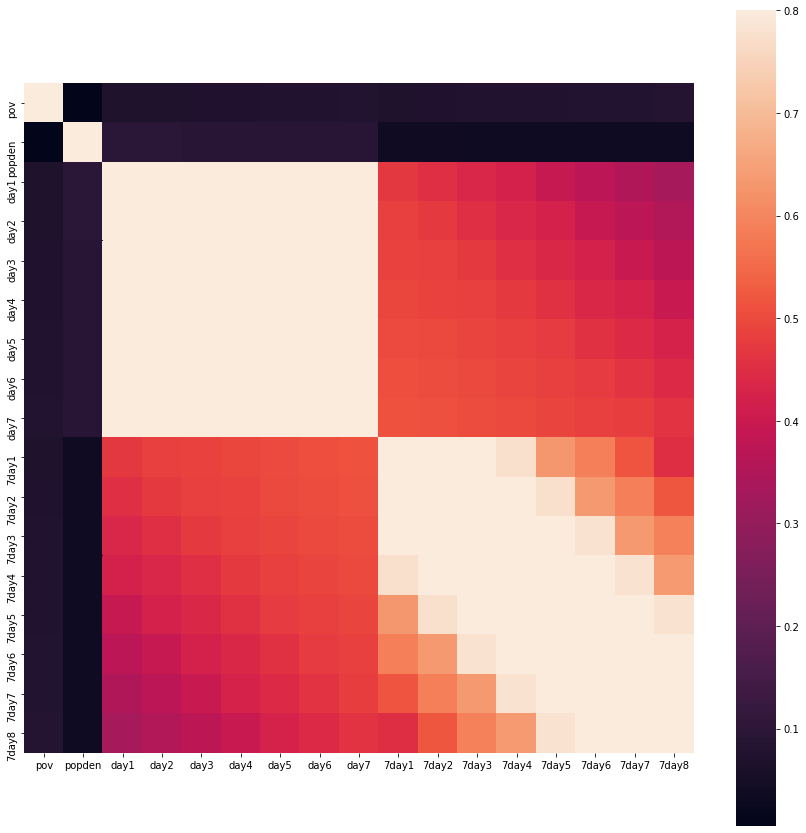

In [15]:
C_mat = cases_popcorrected.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

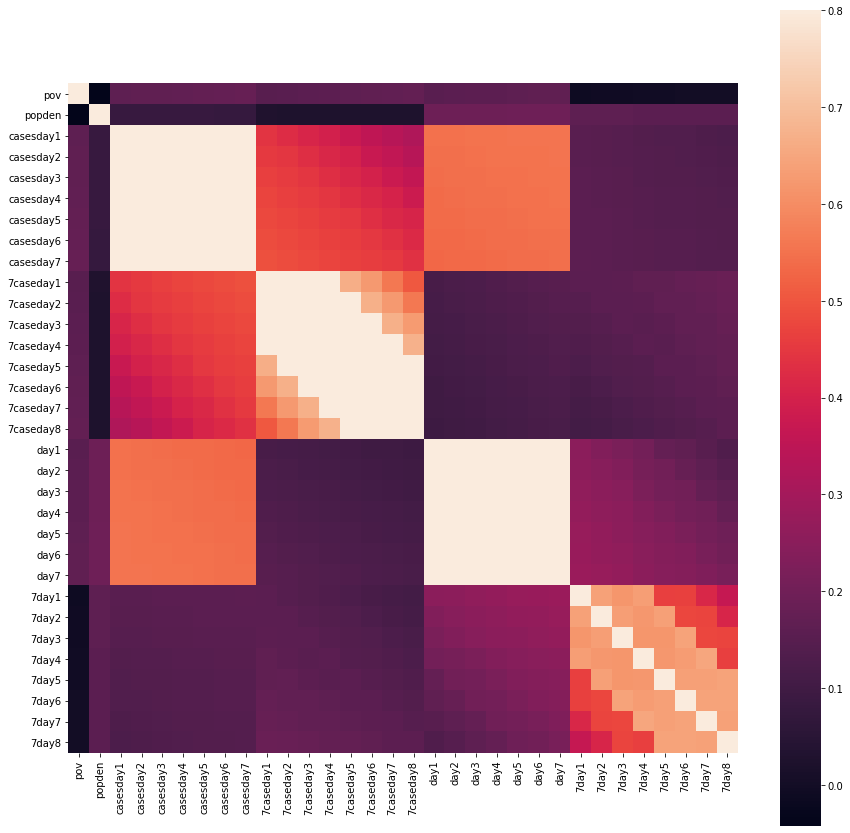

In [16]:
C_mat = deaths_popcorrected.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [17]:
x= cases_popcorrected[['pov','popden','day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']]
y= cases_popcorrected['7day8'].values.reshape(-1, 1)
X = deaths_popcorrected[['pov','popden','casesday1', 'casesday2', 'casesday3', 'casesday4', 'casesday5', 'casesday6', 'casesday7','day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']]
Y = deaths_popcorrected['7day8'].values.reshape(-1, 1)
print(X.shape, Y.shape, x.shape,y.shape)

(204455, 16) (204455, 1) (380111, 9) (380111, 1)


In [18]:
x= cases_popcorrected[['7day4', '7day5', '7day6', '7day7']]
y= cases_popcorrected['7day8'].values.reshape(-1, 1)
X = deaths_popcorrected[['7day4', '7day5', '7day6', '7day7']]
Y = deaths_popcorrected['7day8'].values.reshape(-1, 1)
print(X.shape, Y.shape, x.shape,y.shape)

(204455, 4) (204455, 1) (380111, 4) (380111, 1)


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [20]:
model = Sequential()
model.add(Dense(48, kernel_initializer='normal',activation='relu', input_dim=X_train.shape[1]))
# Add a second hidden layer
model.add(Dense(96, kernel_initializer='normal',activation='relu'))
model.add(Dense(96, kernel_initializer='normal',activation='relu'))
model.add(Dense(96, kernel_initializer='normal',activation='relu'))
# Y_train = to_categorical(Y_train)
# Add output layer
model.add(Dense(1,activation='linear'))
model.compile(loss="mean_squared_error",optimizer="Adamax", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 96)                4704      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97        
Total params: 23,665
Trainable params: 23,665
Non-trainable params: 0
_________________________________________________________________


In [21]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='mean_squared_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
# Use the training data to fit (train) the model
model.fit(X_train,Y_train,epochs=5,shuffle=True,verbose=1)

Epoch 1/5
4792/4792 [==============================] - 2s 482us/step - loss: 0.1441 - accuracy: 0.8483
Epoch 2/5
4792/4792 [==============================] - 2s 484us/step - loss: 0.1390 - accuracy: 0.8490
Epoch 3/5
4792/4792 [==============================] - 2s 486us/step - loss: 0.1382 - accuracy: 0.8494
Epoch 4/5
4792/4792 [==============================] - 2s 490us/step - loss: 0.1370 - accuracy: 0.8494
Epoch 5/5
4792/4792 [==============================] - 2s 484us/step - loss: 0.1361 - accuracy: 0.8495


In [22]:
model2 = Sequential()
model2.add(Dense(27, kernel_initializer='normal',activation='relu', input_dim=x_train.shape[1]))
# Add a second hidden layer
model2.add(Dense(52, kernel_initializer='normal',activation='relu'))
model2.add(Dense(52, kernel_initializer='normal',activation='relu'))
model2.add(Dense(52, kernel_initializer='normal',activation='relu'))
# Y_train = to_categorical(Y_train)
# Add output layer
model2.add(Dense(1,activation='linear'))
model2.compile(loss="mean_squared_error",optimizer="Adamax", metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 27)                135       
_________________________________________________________________
dense_6 (Dense)              (None, 52)                1456      
_________________________________________________________________
dense_7 (Dense)              (None, 52)                2756      
_________________________________________________________________
dense_8 (Dense)              (None, 52)                2756      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 53        
Total params: 7,156
Trainable params: 7,156
Non-trainable params: 0
_________________________________________________________________


In [23]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='mean_squared_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
# Use the training data to fit (train) the model
model2.fit(x_train,y_train,epochs=5,shuffle=True,verbose=1)

Epoch 1/5
8909/8909 [==============================] - 4s 457us/step - loss: 98.3269 - accuracy: 0.1885
Epoch 2/5
8909/8909 [==============================] - 4s 456us/step - loss: 73.5366 - accuracy: 0.2255
Epoch 3/5
8909/8909 [==============================] - 4s 457us/step - loss: 68.8390 - accuracy: 0.2864
Epoch 4/5
8909/8909 [==============================] - 4s 456us/step - loss: 65.7977 - accuracy: 0.3287
Epoch 5/5
8909/8909 [==============================] - 4s 455us/step - loss: 64.6605 - accuracy: 0.3476


Multiple Linear Regression

In [24]:
# from sklearn.preprocessing import StandardScaler

# # Create a StandardScater model and fit it to the training data

# ### BEGIN SOLUTION
# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)
# ### END SOLUTION

In [25]:
# # Transform the training and testing data using the X_scaler and y_scaler models

# ### BEGIN SOLUTION
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
# ### END SOLUTION

In [26]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
### END SOLUTION

LinearRegression()

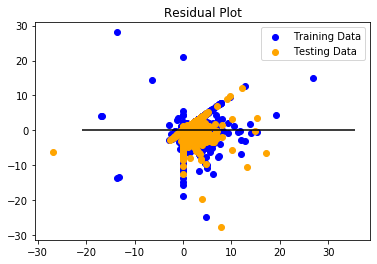

In [27]:
### BEGIN SOLUTION
import matplotlib.pyplot as plt
predictions = model.predict(X_test)
model.fit(X_train, Y_train)
plt.scatter(model.predict(X_train), model.predict(X_train) - Y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - Y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=Y_test.min(), xmax=Y_test.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [28]:
### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(Y_test, predictions)
r2 = model.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.13689104764288404, R2: 0.5825915512601273


In [29]:
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train,Y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
r2 = lasso.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.14193215769615655, R2: 0.5672201886802104


In [30]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, Y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
r2 = ridge.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.1368910509597135, R2: 0.5825915411464445


In [31]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, Y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(Y_test, predictions)
r2 = elasticnet.score(X_test, Y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.13918240256242587, R2: 0.575604747382539


In [32]:
print(f"Training Data Score: {model.score(X_train, Y_train)}")
print(f"Testing Data Score: {model.score(X_test, Y_test)}")

Training Data Score: 0.5476754711576673
Testing Data Score: 0.5825915512601273


In [33]:
#To retrieve the intercept:
print(model.intercept_)
#For retrieving the slope:
print(model.coef_)

[0.02065276]
[[-0.15324441  0.32810944  0.32557366  0.31226568]]


Optimizations and Testing

In [34]:
start = timer()
state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_processed.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
        if temp.iloc[0,1]>0:
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
            state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

23.25170829999996


In [35]:
start = timer()
# state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_popcorrected.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
        if temp.iloc[0,1]>0:
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
#             state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

17.258087299999943


In [36]:
start = timer()
# state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_popcorrected.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_cases.iloc[j,i+1]>0:
            temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
#             state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

14.847218200000043


In [37]:
state_cases.iloc[j,i]

2520

In [38]:
start = timer()
state_cases_popcorrected={}
k=0
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_cases.iloc[j,i+1]>0:
            state_cases_popcorrected[k] = {"day1": (state_cases.iloc[j,i]*100000)/pop,"day2": (state_cases.iloc[j,i+1]*100000)/pop,"day3": (state_cases.iloc[j,i+2]*100000)/pop,"day4": (state_cases.iloc[j,i+3]*100000)/pop,"day5": (state_cases.iloc[j,i+4]*100000)/pop,"day6": (state_cases.iloc[j,i+5]*100000)/pop,"day7": (state_cases.iloc[j,i+6]*100000)/pop,"day8":(state_cases.iloc[j,i+7]*100000)/pop}
            k=k+1
state_cases_popcorrected = pd.DataFrame.from_dict(state_cases_popcorrected, "index")
end = timer()
print(end - start)

0.4375092999999879


In [39]:
state_cases_popcorrected

,day1,day2,day3,day4,day5,day6,day7,day8
0,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803
1,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860
2,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733
3,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000
4,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,3.997402
...,...,...,...,...,...,...,...,...
7625,405.522851,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455
7626,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794
7627,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484
7628,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484,485.176040


In [40]:
state_cases_popcorrected

,day1,day2,day3,day4,day5,day6,day7,day8
0,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803
1,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860
2,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733
3,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000
4,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,3.997402
...,...,...,...,...,...,...,...,...
7625,405.522851,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455
7626,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794
7627,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484
7628,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484,485.176040


In [41]:
cases_popcorrected

,pov,popden,day1,day2,day3,day4,day5,day6,day7,7day1,7day2,7day3,7day4,7day5,7day6,7day7,7day8
0,17.049426,96.054497,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,0.000000,0.000000,0.020395,0.000000,0.081580,0.101975,0.101975,0.244739
1,17.049426,96.054497,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,0.000000,0.020395,0.000000,0.081580,0.101975,0.101975,0.244739,0.285529
2,17.049426,96.054497,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,0.020395,0.000000,0.081580,0.101975,0.101975,0.244739,0.285529,0.305924
3,17.049426,96.054497,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,0.000000,0.081580,0.101975,0.101975,0.244739,0.285529,0.305924,0.407898
4,17.049426,96.054497,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,0.081580,0.101975,0.101975,0.244739,0.285529,0.305924,0.407898,0.489478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372493,16.492958,2.960801,57.745056,57.745056,57.745056,57.745056,72.181319,72.181319,72.181319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
372494,16.492958,2.960801,57.745056,57.745056,57.745056,72.181319,72.181319,72.181319,72.181319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
372495,16.492958,2.960801,57.745056,57.745056,72.181319,72.181319,72.181319,72.181319,72.181319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
372496,16.492958,2.960801,57.745056,72.181319,72.181319,72.181319,72.181319,72.181319,72.181319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
deaths_popcorrected

,pov,popden,casesday1,casesday2,casesday3,casesday4,casesday5,casesday6,casesday7,7caseday1,...,day6,day7,7day1,7day2,7day3,7day4,7day5,7day6,7day7,7day8
0,17.049426,96.054497,4.935567,7.770459,10.544167,11.971810,14.154065,16.825798,18.335021,0.571057,...,0.203949,0.203949,0.0,0.000000,0.000000,0.000000,0.000000,0.020395,0.020395,0.040790
1,17.049426,96.054497,7.770459,10.544167,11.971810,14.154065,16.825798,18.335021,20.129773,0.917771,...,0.203949,0.469083,0.0,0.000000,0.000000,0.000000,0.020395,0.020395,0.040790,0.081580
2,17.049426,96.054497,10.544167,11.971810,14.154065,16.825798,18.335021,20.129773,21.618601,1.244089,...,0.469083,0.550662,0.0,0.000000,0.000000,0.020395,0.020395,0.040790,0.081580,0.040790
3,17.049426,96.054497,11.971810,14.154065,16.825798,18.335021,20.129773,21.618601,25.146920,1.121720,...,0.550662,0.652637,0.0,0.000000,0.020395,0.020395,0.040790,0.081580,0.040790,0.122369
4,17.049426,96.054497,14.154065,16.825798,18.335021,20.129773,21.618601,25.146920,30.490385,1.631593,...,0.652637,0.775006,0.0,0.020395,0.020395,0.040790,0.081580,0.040790,0.122369,0.101975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197613,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
197614,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
197615,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
197616,11.274222,2.049831,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,0.000000,...,11.841326,11.841326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
# # Outdated- categorical

# model2 = Sequential()
# model2.add(Dense(27, activation='relu', input_dim=x_train.shape[1]))
# # Add a second hidden layer
# model2.add(Dense(52, activation='relu'))
# model2.add(Dense(104, activation='relu'))
# model2.add(Dense(208, activation='relu'))
# model2.add(Dense(416, activation='relu'))
# model2.add(Dense(832, activation='relu'))
# model2.add(Dense(1664, activation='relu'))
# model2.add(Dense(3328, activation='relu'))
# model2.add(Dense(6656, activation='relu'))
# y_train = to_categorical(y_train)
# # Add output layer
# model2.add(Dense(y_train.shape[1], activation="softmax"))